This notebook contains Helen's code for loading and getting counts of the Open Secrets candidates and individual contributions files.

In [4]:
# import libraries
import pandas as pd
import regex as re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Set filtering variables for final FEC data set

# Set variables
max_contrib = 1000
contrib_type = "15"
min_date = "2019-01-03" # Matches min date in DC Inbox data
max_date = "2021-01-02" # Matches max date in DC Inbox data

# Set variable use toggles
use_max_contrib = True
use_contrib_type = True
use_date_range = True

In [6]:
# Read in the candidates table, incumbents only

column_names = ["Cycle", "FECCandID", "CID", "FirstLastP",
                "Party", "DistIDRunFor", "DistIDCurr", "CurrCand",
                "CycleCand", "CRPICO", "RecipCode", "NoPacs"]

cand_df = pd.read_csv("C:/Users/hefla/Documents/Work/IPS/Area 990/Data Sources/Politicking/cands20.txt", 
                      sep = ",", # separated by commas
                      quotechar = "|", # fields are surrounded by pipes
                      encoding = "latin1",
                      header = None,
                      names = column_names
)

# Incumbents only
cand_df["DistIDCurr"] = cand_df["DistIDCurr"].astype(str).str.strip()
cand_df = cand_df[
    cand_df["DistIDCurr"].notna() &
    (cand_df["DistIDCurr"] != "") &
    (cand_df["DistIDCurr"] != "PRES") &
    (cand_df["DistIDCurr"].str.lower() != "nan")
]

cand_df.head()


,Cycle,FECCandID,CID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs
13,2020,H0AL02087,N00030768,Martha Roby (R),R,AL02,AL02,,,I,RI,
24,2020,H0AL05163,N00030910,Mo Brooks (R),R,AL05,AL05,Y,Y,I,RW,
28,2020,H0AL07086,N00030622,Terri A Sewell (D),D,AL07,AL07,Y,Y,I,DW,
30,2020,H0AR01083,N00030770,Rick Crawford (R),R,AR01,AR01,Y,Y,I,RW,
37,2020,H0AR03055,N00031857,Steve Womack (R),R,AR03,AR03,Y,Y,I,RW,


In [7]:
# Read in the individual contributions table

column_names = ["Cycle", "FECTransIS", "ContribID", "Contrib",
                "RecipID", "Orgname", "UltOrg", "RealCode",
                "Date", "Amount", "Street", "City",
                "State", "Zip", "RecipCode", "Type",
                "CmteID", "OtherID", "Gender", "Microfilm",
                "Occupation", "Employer", "Source"]

contrib_df = pd.read_csv("C:/Users/hefla/Documents/Work/IPS/Area 990/Data Sources/Politicking/indivs20.txt", 
                      sep = ",", # separated by commas
                      quotechar = "|", # fields are surrounded by pipes
                      encoding = "latin1",
                      header = None,
                      names = column_names,
                      low_memory = False
)

contrib_df.head()

,Cycle,FECTransIS,ContribID,Contrib,RecipID,Orgname,UltOrg,RealCode,Date,Amount,...,Zip,RecipCode,Type,CmteID,OtherID,Gender,Microfilm,Occupation,Employer,Source
0,2020,4030220201214334986,p0004869853,"LONNBERG, CARL",C00721712,[24T Contribution],NaN,Z9500,12/20/2019,10000,...,94117,DP,24T,C00401224,C00721712,M,202001299171851035,PARTNER,BOSTON CONSULTING GROUP,Rept
1,2020,4030220201214334988,k0001516259,"LOVO, MARIO",N00044240,[24T Contribution],NaN,Z9500,12/08/2019,250,...,33134,DL,24T,C00401224,C00696153,M,202001299171881052,LAWYER,SELF,Rept
2,2020,4030220201214335206,h3003526289,"LOGUE, KATHERINE",C00401224,NaN,NaN,J1200,07/09/2019,5,...,60010,PI,15,C00401224,NaN,F,202001299171836150,NOT EMPLOYED,NONE,P/PAC
3,2020,4051220201742609379,m00016536071,"YINGLING, JOHN",N00044240,Steamboat Wharf of Provincetown,NaN,G2900,01/20/2020,25,...,02657,DL,15E,C00696153,C00401224,M,202004159219618050,RESTAURANT MANAGER,STEAMBOAT WHARF OF PROVINCETOWN,temp
4,2020,4051220201742609381,i3003912456,"YODAIKEN, VICTOR",N00044240,Finite State Machine Labs,NaN,Z9600,03/31/2020,250,...,78733,DL,15E,C00696153,C00401224,M,202004159219618050,BUSINESSMAN,FINITE STATE MACHINE LABS INC.,RptEF


In [8]:
# Field cleanup for candidates table

# Split the DistIDCurr (current district) field into separate columns for state and district (as integer)
cand_df["State"] = cand_df["DistIDCurr"].str[0:2]
cand_df["District"] = cand_df["DistIDCurr"].str[2:4].fillna(0)
cand_df.loc[cand_df["District"].astype(str).str.startswith("S"), "District"] = "0"
cand_df["District"] = cand_df["District"].astype(int)

# Strip off anything fitting the pattern " (<Party>)" at the end of the LastFirstP field
cand_df['FirstLastP'] = cand_df.apply(
    lambda row: row['FirstLastP'].replace(f" ({row['Party']})", ""),
    axis=1
)

# Rename party column to Party Original
# Add party column that just is one character mapped to D, R, or O (Other)
cand_df.rename(columns={"Party": "Party Original"}, inplace = True)
cand_df["Party"] = (
    cand_df["Party Original"]
    .fillna("")
    .astype(str)
    .str[0]
    .str.upper()
    .map({"D": "D", "R": "R"})
    .fillna("O")
)

# Strip off any remaining single-character codes of D, R, 3, or I surrounded by parentheses 
# at the end of candidate names (leaving all other things in parentheses intact)
cand_df['FirstLastP'] = cand_df['FirstLastP'].str.replace(
    r"\s*\((D|R|3|I)\)$", "", regex=True
)

# Trim off any trailing whitespaces from LsatFirstP
cand_df['FirstLastP'] = cand_df['FirstLastP'].str.strip()

# Make sure the candidate full name, party, and state fields are uppercased
cand_df["FirstLastP"] = cand_df["FirstLastP"].str.upper()
cand_df["Party"] = cand_df["Party"].str.upper()
cand_df["State"] = cand_df["State"].str.upper()

# cand_df.info()
# print(cand_df.columns)
cand_df.head()

,Cycle,FECCandID,CID,FirstLastP,Party Original,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,State,District,Party
13,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R
24,2020,H0AL05163,N00030910,MO BROOKS,R,AL05,AL05,Y,Y,I,RW,,AL,5,R
28,2020,H0AL07086,N00030622,TERRI A SEWELL,D,AL07,AL07,Y,Y,I,DW,,AL,7,D
30,2020,H0AR01083,N00030770,RICK CRAWFORD,R,AR01,AR01,Y,Y,I,RW,,AR,1,R
37,2020,H0AR03055,N00031857,STEVE WOMACK,R,AR03,AR03,Y,Y,I,RW,,AR,3,R


In [29]:
# QC of third party politicians
print(cand_df["Party"].value_counts())

indie_rows = cand_df[cand_df["Party"] == "O"]
print(indie_rows[["CID", "FirstLastP", "Party", "Party Original"]])

# dcinbox_3p_df = cand_df[cand_df["FirstLastP"].str.contains("KING")]
# print(dcinbox_3p_df)

Party
D    281
R    252
O      5
Name: count, dtype: int64
            CID          FirstLastP Party Party Original
3691  N00037615  JENNIFFER GONZALEZ     O              3
4554  N00030418     GREGORIO SABLAN     O              I
6461  N00031938        JUSTIN AMASH     O              L
7546  N00034580          ANGUS KING     O              I
7688  N00000528      BERNIE SANDERS     O              I


In [10]:
# QC of contribution date before filtering 
contrib_df["Date"] = pd.to_datetime(contrib_df["Date"], errors='coerce')

print("Min Date:", contrib_df["Date"].min())
print("Max Date:", contrib_df["Date"].max())

Min Date: 2000-06-16 00:00:00
Max Date: 2030-09-29 00:00:00


In [11]:
# Field cleanup and filtering for individual contributions table

print(len(contrib_df))

contrib_df["Type"] = contrib_df["Type"].str.strip()
contrib_df["Date"] = pd.to_datetime(contrib_df["Date"], errors='coerce')

# Filter out politicians that are not incumbents (DistIDCurr not null)
# Or they're not currently the president (DistIDCurr = 'PRES')
# Or they're not senators (District = 0)
cand_df_filtered = cand_df[
    (cand_df['DistIDCurr'].notnull()) & 
    (cand_df['District'] != 0) & 
    (cand_df['DistIDCurr'] != "PRES")
]

# Filter to contrib_type 15 (regular contributions, not soft money or earmarked contributions)
# max_contrib = 1000
if use_contrib_type:
    contrib_filtered_df = contrib_df[contrib_df["Type"] == contrib_type].copy()
if use_max_contrib:
    contrib_filtered_df = contrib_df[contrib_df["Amount"] <= max_contrib].copy()
if use_date_range:
        contrib_filtered_df = contrib_df[contrib_df["Date"].between(min_date, max_date)].copy()

print(len(contrib_filtered_df))

37145943
37075550


In [12]:
# QC of contribution date after filtering 
contrib_filtered_df["Date"] = pd.to_datetime(contrib_filtered_df["Date"], errors='coerce')

print("Min Date:", contrib_filtered_df["Date"].min())
print("Max Date:", contrib_filtered_df["Date"].max())

Min Date: 2019-01-03 00:00:00
Max Date: 2020-12-31 00:00:00


In [13]:
# Join candidates and individual contributions into a new data frame
# with summary columns on contribution day, count, and amount
# for each incumbent candidate

contrib_filtered_df['Date'] = pd.to_datetime(contrib_filtered_df['Date'])

# Group contributions by recipient and date
daily_contrib_sum = (
    contrib_filtered_df
    .groupby(['RecipID', contrib_filtered_df['Date'].dt.date])  # group by candidate and day
    .agg(
        contrib_count=('Amount', 'count'),    # number of contributions
        contrib_amount=('Amount', 'sum')      # total amount per day
    )
    .reset_index()
    .rename(columns={'Date': 'contrib_date'})  # rename date column
)

# Merge the daily contributions summary data with the candidate data (left join)
cand_contrib_df = cand_df_filtered.merge(
    daily_contrib_sum,
    left_on = 'CID',
    right_on = 'RecipID',
    how = 'left'
)

# Drop the RecipID column (don't need it since we have CID)
cand_contrib_df = cand_contrib_df.drop(columns=['RecipID'])

# Fill missing counts and amounts with 0 for candidates with no contributions (per day)
cand_contrib_df['contrib_count'] = cand_contrib_df['contrib_count'].fillna(0).astype(int)
cand_contrib_df['contrib_amount'] = cand_contrib_df['contrib_amount'].fillna(0)

cand_contrib_df.head()

,Cycle,FECCandID,CID,FirstLastP,Party Original,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,State,District,Party,contrib_date,contrib_count,contrib_amount
0,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-01-10,1,2500.0
1,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-02-25,1,500.0
2,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-02-28,2,750.0
3,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-03-14,2,1000.0
4,2020,H0AL02087,N00030768,MARTHA ROBY,R,AL02,AL02,,,I,RI,,AL,2,R,2019-03-28,1,500.0


In [14]:
# Output the filtered, merged candidate contributions data frame to a CSV file for use later in creating the final data set for analysis

print(len(cand_contrib_df))

cand_contrib_df.to_csv(
#     r"C:\Users\hefla\Documents\Work\IPS\Area 990\Data Sources\Politicking\cand_contrib_summary_2020.csv",
    "../data/fec/candidate_contributions_2020_test.csv",
    index=False,  # no row numbers
    encoding="latin1"
)

122459


In [15]:
# MICHAEL THIS IS THE IMPORTANT STUFF

cand_contrib_df['contrib_date'] = pd.to_datetime(cand_contrib_df['contrib_date'])
                
monthly_analysis_df = cand_contrib_df[(cand_contrib_df['FirstLastP'].str.contains("PELOSI"))]

monthly_analysis_df = monthly_analysis_df[["FirstLastP", "CID", "contrib_date", "contrib_count", "contrib_amount"]]

print(monthly_analysis_df)

         FirstLastP        CID contrib_date  contrib_count  contrib_amount
71667  NANCY PELOSI  N00007360   2019-01-03             30          2494.0
71668  NANCY PELOSI  N00007360   2019-01-04             27          2026.0
71669  NANCY PELOSI  N00007360   2019-01-05             22           688.0
71670  NANCY PELOSI  N00007360   2019-01-06             17           878.0
71671  NANCY PELOSI  N00007360   2019-01-07             17           516.0
...             ...        ...          ...            ...             ...
72364  NANCY PELOSI  N00007360   2020-12-27             40          5662.0
72365  NANCY PELOSI  N00007360   2020-12-28             27         11780.0
72366  NANCY PELOSI  N00007360   2020-12-29             62         28318.0
72367  NANCY PELOSI  N00007360   2020-12-30             53         26150.0
72368  NANCY PELOSI  N00007360   2020-12-31             74         29598.0

[702 rows x 5 columns]


In [16]:
# Aggregate monthly totals including count
monthly_sum_df = (
    monthly_analysis_df
    .groupby(monthly_analysis_df['contrib_date'].dt.to_period('M'))
    .agg(
        contrib_amount=('contrib_amount', 'sum'),
        contrib_count=('contrib_count', 'sum')
    )
    .reset_index()
)

# Convert PeriodIndex to timestamp for plotting
# monthly_sum_df['contrib_date'] = monthly_sum_df['contrib_date'].dt.to_timestamp()

# Compute average contribution per month
# monthly_sum_df['avg_contrib'] = monthly_sum_df['contrib_amount'] / monthly_sum_df['contrib_count']

# Optional: check the result
print(monthly_sum_df.head())

  contrib_date  contrib_amount  contrib_count
0      2019-01         68967.0            649
1      2019-02        352867.0            800
2      2019-03        500398.0           1181
3      2019-04        328176.0           1399
4      2019-05        417697.0           1413


In [20]:
# Convert PeriodIndex to DataFrame and reset the index
# monthly_sum_df = monthly_sum.reset_index()

# Convert Period to timestamp
monthly_sum_df['contrib_date'] = monthly_sum_df['contrib_date'].dt.to_timestamp()

# Extract month-year for labeling
monthly_sum_df['month_year'] = monthly_sum_df['contrib_date'].dt.strftime('%b %Y')

# Extract year and month for sorting
monthly_sum_df['year'] = monthly_sum_df['contrib_date'].dt.year
monthly_sum_df['month_num'] = monthly_sum_df['contrib_date'].dt.month

# Optional: filter for 2019 and 2020 only
# monthly_sum_df = monthly_sum_df[monthly_sum_df['year'].isin([2019, 2020])]

# Sort by year and month
monthly_sum_df = monthly_sum_df.sort_values(['year', 'month_num'])

# Create the grouped bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=monthly_sum_df,
    x='month_year',
    y='contrib_amount'
    # palette='Set2'
)

# Beautify the plot
plt.title("Total Contributions by Month (2019-2020)")
plt.xlabel("")
plt.ylabel("Total Contribution Amount")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

AttributeError: 'DatetimeProperties' object has no attribute 'to_timestamp'

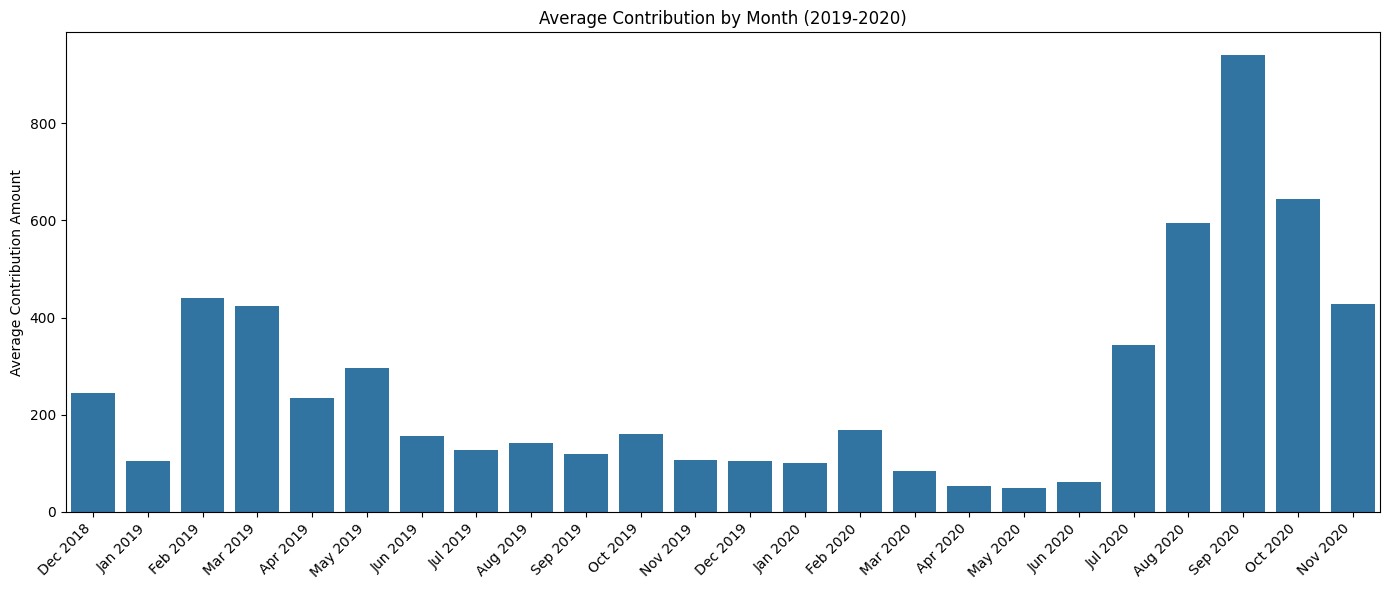

In [ ]:
# Aggregate monthly totals including count
monthly_sum_df = (
    monthly_analysis_df
    .groupby(monthly_analysis_df['contrib_date'].dt.to_period('M'))
    .agg(
        contrib_amount=('contrib_amount', 'sum'),
        contrib_count=('contrib_count', 'sum')
    )
    .reset_index()
)
# 2. Convert the Period column to a proper datetime
# The first column after reset_index() is the period
monthly_sum_df['contrib_date'] = monthly_sum_df[monthly_sum_df.columns[0]].dt.start_time

# 3. Compute average contribution
monthly_sum_df['avg_contrib'] = monthly_sum_df['contrib_amount'] / monthly_sum_df['contrib_count']

# 4. Create month-year labels
monthly_sum_df['month_year'] = monthly_sum_df['contrib_date'].dt.strftime('%b %Y')
monthly_sum_df['year'] = monthly_sum_df['contrib_date'].dt.year
monthly_sum_df['month_num'] = monthly_sum_df['contrib_date'].dt.month

# 5. Sort chronologically
monthly_sum_df = monthly_sum_df.sort_values(['year', 'month_num'])

# Optional: check the DataFrame
# print(monthly_sum_df.head())

# 6. Plot average contributions
plt.figure(figsize=(14,6))
sns.barplot(
    data=monthly_sum_df,
    x='month_year',
    y='avg_contrib'
    # palette='Set2'
)
plt.title("Average Contribution by Month (2019-2020)")
plt.xlabel("")
plt.ylabel("Average Contribution Amount")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Top recipients

group_counts = cand_contrib_df.groupby("FirstLastP")["contrib_amount"].sum()
top_groups = group_counts.sort_values(ascending=False)
top_groups_formatted = top_groups.map(lambda x: f"${x:,.0f}")

print(top_groups_formatted)


FirstLastP
STEVE SCALISE      $25,179,290
JOE KENNEDY III    $12,083,543
MAX ROSE           $10,126,612
ELISSA SLOTKIN      $9,447,707
KEVIN MCCARTHY      $9,338,102
                      ...     
ROB BISHOP                  $0
MARTHA ROBY            $-3,134
ROB WOODALL            $-4,978
FRANCIS ROONEY         $-8,600
DENNIS HECK           $-10,208
Name: contrib_amount, Length: 432, dtype: object


This is where the matching file is built.

In [22]:
# Create a data frame that only has the columns we need for matchings

cand_contrib_df['contrib_date'] = pd.to_datetime(cand_contrib_df['contrib_date'])

cand_contrib_matching_df = cand_contrib_df[["FirstLastP", "CID", "Party", "State", "District", "Cycle"]].rename(
    columns={
        "FirstLastP": "name",
        "CID": "id",
        "Party": "match_attribute1",
        "State": "match_attribute2",
        "District": "match_attribute3",
        "Cycle": "append_attribute1",
        "": "append_attribute2",
        "": "append_attribute3"
    }
)

# Drop duplicate rows based on all columns
cand_contrib_matching_df = cand_contrib_matching_df.drop_duplicates()

# Adding blank columns needed for python matching process
cand_contrib_matching_df["append_attribute2"] = ""
cand_contrib_matching_df["append_attribute3"] = ""

print(len(cand_contrib_matching_df))
cand_contrib_matching_df.head()

432


,name,id,match_attribute1,match_attribute2,match_attribute3,append_attribute1,append_attribute2,append_attribute3
0,MARTHA ROBY,N00030768,R,AL,2,2020,,
18,MO BROOKS,N00030910,R,AL,5,2020,,
109,TERRI A SEWELL,N00030622,D,AL,7,2020,,
299,RICK CRAWFORD,N00030770,R,AR,1,2020,,
370,STEVE WOMACK,N00031857,R,AR,3,2020,,


In [23]:
# Output the joined cand_contrib_df to a CSV file for use in the matching process

cand_contrib_matching_df.to_csv(
    "../matching/match_candidates_2020_test.csv",
    index=False,  # no row numbers
    encoding="latin1"
)